In [6]:
from species import SpeciesInit
from species.data.database import Database
from species.read.read_color import ReadColorMagnitude
from species.plot.plot_color import plot_color_magnitude
from species.fit.fit_model import FitModel

from species.plot.plot_mcmc import plot_posterior
from species.read.read_model import ReadModel
from species.plot.plot_spectrum import plot_spectrum
from species.util.box_util import update_objectbox
from species.util.fit_util import get_residuals, multi_photometry

from species.read.read_isochrone import ReadIsochrone
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

import math

problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


C:\Users\benlc\hd47127b\spec\Lib\site-packages\species\fit\fit_model.py:25: UserWarning: PyMultiNest could not be imported. Perhaps because MultiNest was not built and/or found at the LD_LIBRARY_PATH (Linux) or DYLD_LIBRARY_PATH (Mac)?
  warnings.warn(


In [2]:
SpeciesInit()

species v0.9.0

Working folder: C:\Users\benlc\hd47127b\species

Configuration file: C:\Users\benlc\hd47127b\species\species_config.ini
Database file: C:\Users\benlc\hd47127b\species\species_database.hdf5
Data folder: C:\Users\benlc\hd47127b\species\data

Configuration settings:
   - Database: C:\Users\benlc\hd47127b\species\species_database.hdf5
   - Data folder: C:\Users\benlc\hd47127b\species\data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


In [4]:
database = Database()

In [26]:
database.add_filter('Keck/NIRC2.CH4s', 'micron_Keck_NIRC2.CH4s.txt')

Adding filter: Keck/NIRC2.CH4s... [DONE]


In [27]:
import numpy as np

wv, throughput = np.loadtxt('Keck_NIRC2.CH4s.csv', unpack=True)

In [90]:
np.savetxt('micron_Keck_NIRC2.CH4s.txt', np.array([wv / 10000, throughput]).T)

In [5]:

# H - 13.2794   contrast
# Ks- 13.7977   d = 26.6pc     
# CH4s - 13.1611   conv to apparent
# J - 12.8461             
appmag = {
    # 'Keck/NIRC2.H': (13.2794+5.277, 0.0014),   # alpha = [a, a_error]
    # 'Keck/NIRC2.Ks': (13.7977+5.174, 0.0010),  # contrast = log_10(a * flux ratio)
    # 'Keck/NIRC2.J': (12.8461+5.561, 0.0011),   # contrast_error = log_10((a + a_error) * flux ratio) - log_10(a * flux ratio)
    # 'Keck/NIRC2.CH4s': (13.1611+5.383, 0.0007)   # UPDATE TO USE FLUX RATIO ACTUALLY, IT ASSUMES flux ratio = 1 RIGHT NOW
    
    'Keck/NIRC2.H': (13.3430+5.277, 0.035515+.034),   # alpha = [a, a_error]
    'Keck/NIRC2.Ks': (14.1635+5.174, 0.072289+.023),  # contrast = log_10(a * flux ratio)
    'Keck/NIRC2.CH4s': (13.5163+5.383, 0.038287),   # contrast_error = log_10((a + a_error) * flux ratio) - log_10(a * flux ratio)
    'Keck/NIRC2.J': (13.1904+5.561, 0.068440+.029) #Ks - 0.000613, J - .002008, CH4s - .000008

    # delta mag = 2.5/ln(10) * dalpha/alpha
}

print(appmag)
    
database.add_object('hd47127b', parallax=(37.561, .01), distance=(26.6, 0.008), app_mag=appmag)

database.get_object('hd47127b')

#alpha error, background error 1xbandpasses, stddev of center circle of star image x bandpasses
#atmo-ceq, she might be a binary system!!

{'Keck/NIRC2.H': (18.62, 0.069515), 'Keck/NIRC2.Ks': (19.337500000000002, 0.09528900000000001), 'Keck/NIRC2.CH4s': (18.8993, 0.038287), 'Keck/NIRC2.J': (18.7514, 0.09744)}

----------
Add object
----------

Object name: hd47127b
Units: None
Deredden: None
Parallax (mas) = 37.56 +/- 0.01
Distance (pc) = 26.60 +/- 0.01

Magnitudes:
   - Keck/NIRC2.H:
      - Mean wavelength (um) = 1.2483e+00
      - Apparent magnitude = 18.62 +/- 0.07
      - Flux (W m-2 um-1) = 4.26e-17 +/- 2.73e-18
   - Keck/NIRC2.Ks:
      - Mean wavelength (um) = 1.2483e+00
      - Apparent magnitude = 19.34 +/- 0.10
      - Flux (W m-2 um-1) = 8.19e-18 +/- 7.20e-19
   - Keck/NIRC2.CH4s:
      - Mean wavelength (um) = 1.2483e+00
      - Apparent magnitude = 18.90 +/- 0.04
      - Flux (W m-2 um-1) = 3.40e-17 +/- 1.20e-18
   - Keck/NIRC2.J:
      - Mean wavelength (um) = 1.2483e+00
      - Apparent magnitude = 18.75 +/- 0.10
      - Flux (W m-2 um-1) = 9.64e-17 +/- 8.66e-18

----------
Get object
----------

Object na

In [41]:
# model_name='bt-settl'
# model_name='sonora-bobcat'
# model_name='exo-rem'
# model_name='morley-2012'
# model_name='ames-cond'
# model_name='atmo-ceq'
model_name='saumon2008-clear'

In [42]:
database.add_model(model=model_name, wavel_range=(.8, 3.))


-------------------------
Add grid of model spectra
-------------------------

Database tag: saumon2008-clear
Model name: Saumon & Marley (2008) clear

Unpacking 208/208 model spectra from Saumon & Marley (2008) clear (197 Mb)... [DONE]

Wavelength range (um) = 0.8 - 3.0
Sampling (lambda/d_lambda) = 5000
Teff range (K) = 500 - 2400

Adding Saumon & Marley (2008) clear model spectra... data\saumon2008-clear\saumon2008-clear_teff_965_logg_5.44_spec.dat 

Grid points stored in the database:
   - Teff = [ 500.  525.  550.  575.  600.  625.  650.  685.  690.  700.  730.  750.
  775.  780.  781.  800.  820.  840.  850.  860.  900.  904.  910.  950.
  965. 1000. 1100. 1200. 1210. 1250. 1300. 1400. 1500. 1600. 1700. 1800.
 1900. 2000. 2100. 2200. 2300. 2400.]
   - log(g) = [3.48 4.   4.22 4.25 4.48 4.66 4.68 4.75 4.76 4.84 4.89 4.95 5.   5.02
 5.04 5.09 5.1  5.13 5.14 5.17 5.23 5.25 5.37 5.38 5.43 5.44 5.48]

Number of grid points per parameter:
   - teff: 42
   - logg: 27


C:\Users\benlc\hd47127b\spec\Lib\site-packages\species\util\data_util.py:397: RuntimeWarning: divide by zero encountered in log10
  flux = np.log10(flux)



Fix missing grid points with a linear interpolation:
   - teff = 500.0, logg = 4.22
   - teff = 500.0, logg = 4.66
   - teff = 500.0, logg = 4.68
   - teff = 500.0, logg = 4.76
   - teff = 500.0, logg = 4.84
   - teff = 500.0, logg = 4.89
   - teff = 500.0, logg = 4.95
   - teff = 500.0, logg = 5.02
   - teff = 500.0, logg = 5.04
   - teff = 500.0, logg = 5.09
   - teff = 500.0, logg = 5.1
   - teff = 500.0, logg = 5.13
   - teff = 500.0, logg = 5.14
   - teff = 500.0, logg = 5.17
   - teff = 500.0, logg = 5.23
   - teff = 500.0, logg = 5.37
   - teff = 500.0, logg = 5.38
   - teff = 500.0, logg = 5.43
   - teff = 500.0, logg = 5.44
   - teff = 525.0, logg = 4.22
   - teff = 525.0, logg = 4.25
   - teff = 525.0, logg = 4.48
   - teff = 525.0, logg = 4.66
   - teff = 525.0, logg = 4.68
   - teff = 525.0, logg = 4.75
   - teff = 525.0, logg = 4.76
   - teff = 525.0, logg = 4.84
   - teff = 525.0, logg = 4.89
   - teff = 525.0, logg = 4.95
   - teff = 525.0, logg = 5.0
   - teff = 525.0,

In [43]:
inc_phot = ['Keck/NIRC2.H', 'Keck/NIRC2.Ks', 'Keck/NIRC2.J', 'Keck/NIRC2.CH4s']

fit = FitModel(object_name='hd47127b', 
               model=model_name, 
               bounds={},
               inc_phot=inc_phot, 
               inc_spec=False, 
               fit_corr=None, 
               apply_weights=False, 
               normal_prior={'mass': (83.9, 11)})


-----------------
Fit model spectra
-----------------

Object name: hd47127b
Model tag: saumon2008-clear
Binary star: False
Blackbody components: 0
Teff interpolation range: (500.0, 2400.0)

Interpolating Keck/NIRC2.H... [DONE]
Interpolating Keck/NIRC2.Ks... [DONE]
Interpolating Keck/NIRC2.J... [DONE]
Interpolating Keck/NIRC2.CH4s... [DONE]

Fitting 4 parameters:
   - teff
   - logg
   - radius
   - parallax

Uniform priors (min, max):
   - teff = (500.0, 2400.0)
   - logg = (3.48, 5.48)
   - radius = (0.5, 5.0)

Normal priors (mean, sigma):
   - mass = 83.90 +/- 11.00
   - parallax = 37.56 +/- 0.01

Weights for the log-likelihood function:
   - Keck/NIRC2.H = 1.00
   - Keck/NIRC2.Ks = 1.00
   - Keck/NIRC2.J = 1.00
   - Keck/NIRC2.CH4s = 1.00


In [44]:
fit.run_ultranest(tag='hd47127b', min_num_live_points=400, resume=False, output='ultranest/', kwargs_ultranest=None)


------------------------------
Nested sampling with UltraNest
------------------------------

Database tag: hd47127b
Minimum number of live points: 400
Resume previous fit: False
Output folder: ultranest/

Creating directory for new run ultranest/run37
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=1e+02   [112.6557..112.6565]*| it/evals=7040/27244 eff=26.2256% N=400  00 0 0  0 0 00   
[ultranest] Likelihood function evaluations: 27250
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 99.75 +- 0.1142
[ultranest] Effective samples strategy satisfied (ESS = 2395.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

Log-evidence 


---------------------
Get posterior samples
---------------------

Database tag: hd47127b
Random samples: None
Samples shape: (7444, 4)

Parameters:
   - teff
   - logg
   - radius
   - parallax

Uniform priors (min, max):
   - logg = (3.48, 5.48)
   - radius = (0.5, 5.0)
   - teff = (500.0, 2400.0)

Normal priors (mean, sigma):
   - mass = (83.9, 11.0)
   - parallax = (37.561, 0.01)

----------------------------
Plot posterior distributions
----------------------------

Database tag: hd47127b
Object type: planet
Manual parameters: None

Model type: atmosphere
Model name: saumon2008-clear
Sampler: ultranest

Median parameters:
   - teff = 8.34e+02
   - logg = 5.45e+00
   - radius = 5.52e-01
   - parallax = 3.76e+01

Sample with highest probability:
   - teff = 8.39e+02
   - logg = 5.47e+00
   - radius = 5.41e-01
   - parallax = 3.76e+01

Parameters included in corner plot:
   - teff
   - logg
   - radius
   - parallax
   - log_lum_atm
   - mass

Output: saumon2008-clear_spec_corner.pd

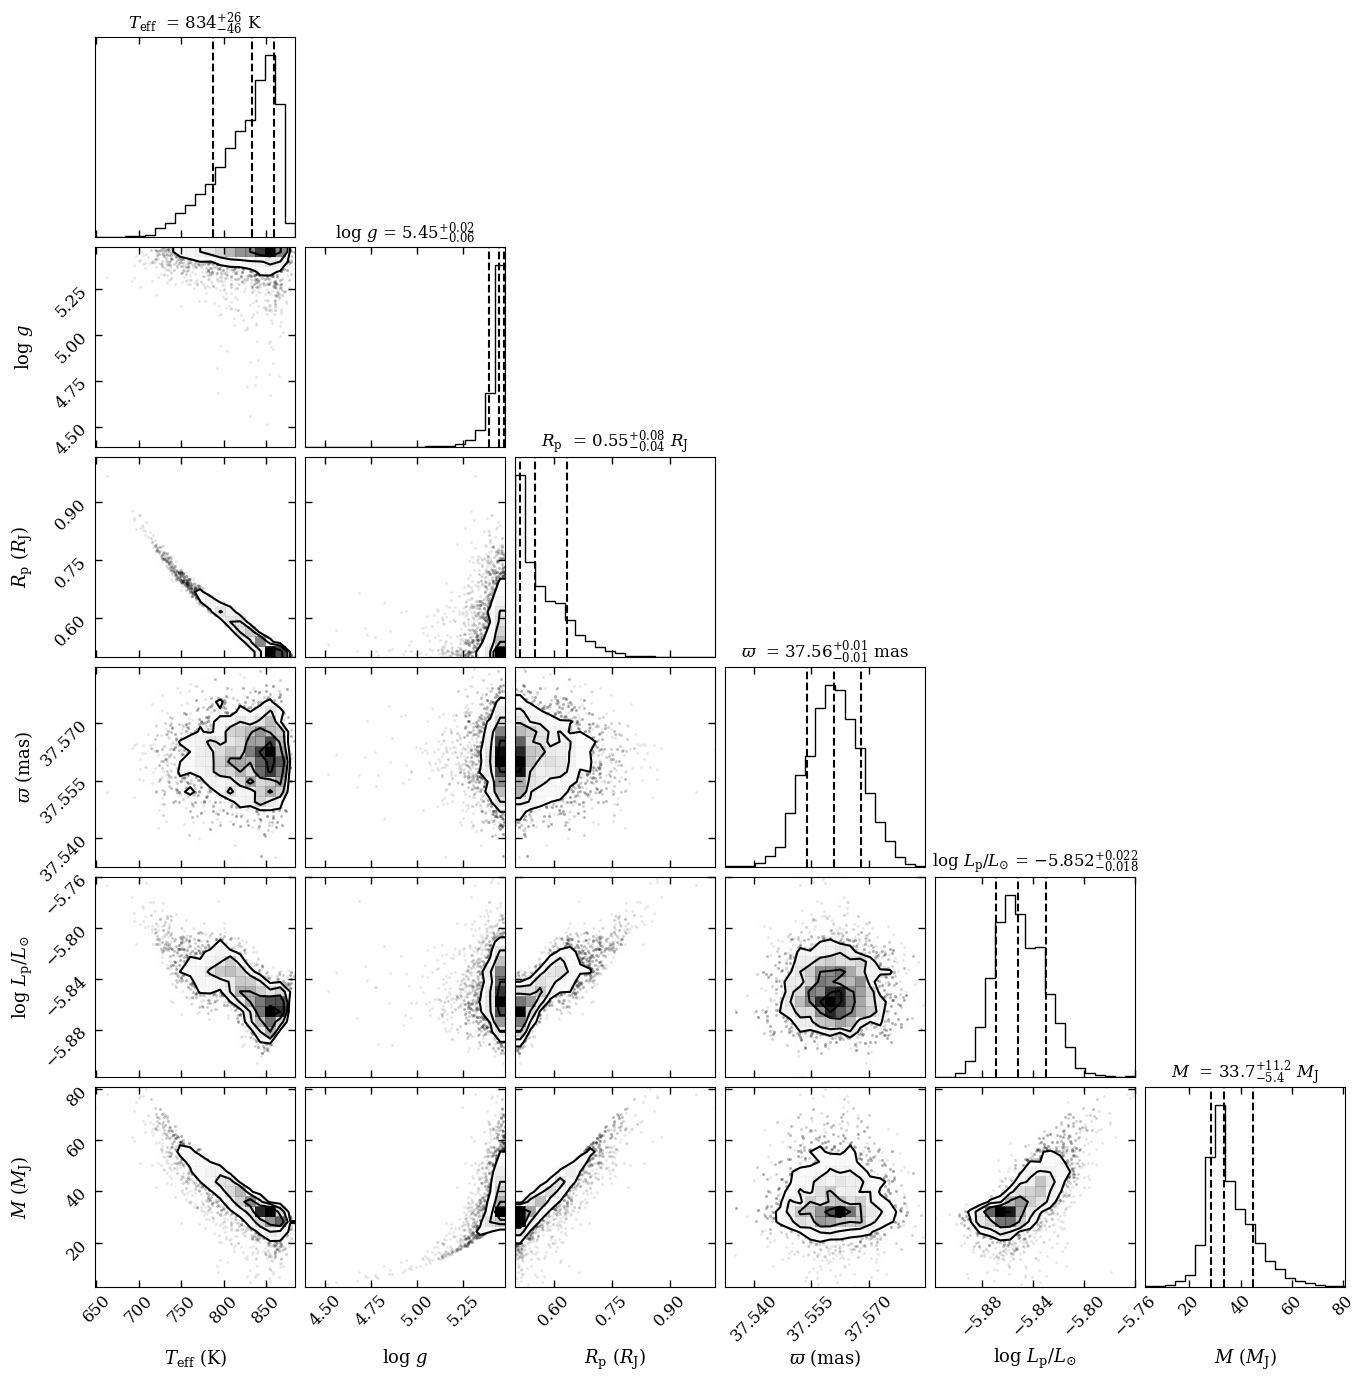

In [45]:
fig = plot_posterior(tag='hd47127b',
                     offset=(-0.3, -0.3),
                     title_fmt=['.0f','.2f','.2f', '.2f', '.3f', '.1f'],
                     inc_luminosity=True,
                     inc_mass=True,
                     output=model_name + '_spec_corner.pdf')

In [46]:
samples = database.get_mcmc_spectra(tag='hd47127b',
                                    random=30,
                                    wavel_range=None,
                                    spec_res=500.)


---------------------
Get posterior spectra
---------------------

Database tag: hd47127b
Number of samples: 30
Wavelength range (um): None
Resolution: 500.0



  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
samples[0].open_box()

Opening ModelBox...
model = bt-settl
type = None
wavelength = [0.80006021 0.80013945 0.8002187  ... 5.99831788 5.99891198 5.99950613]
flux = [1.93016075e-19 1.93460180e-19 1.93943326e-19 ... 2.65389403e-18
 2.72480796e-18 2.79122439e-18]
parameters = {'teff': 830.8393282431973, 'logg': 5.41472320932106, 'radius': 0.5924054098414944, 'parallax': 37.55434438420391, 'log_lum_atm': -5.798329219691508, 'log_lum': -5.798329219691508, 'mass': 36.79134743575917}
quantity = flux
contribution = None
bol_flux = None
spec_res = 500.0


In [15]:
print(samples[0].wavelength)

[0.80006021 0.80013945 0.8002187  ... 5.99831788 5.99891198 5.99950613]


In [47]:
best = database.get_median_sample(tag='hd47127b')


---------------------
Get median parameters
---------------------

Database tag: hd47127b

Parameters:
   - teff = 833.66
   - logg = 5.45
   - radius = 0.55
   - parallax = 37.56


In [48]:
read_model = ReadModel(model=model_name, wavel_range=None)

In [49]:
modelbox = read_model.get_model(model_param=best, spec_res=1000.)

In [50]:
objectbox = database.get_object(object_name='hd47127b',
                                inc_phot=True,
                                inc_spec=True)


----------
Get object
----------

Object name: hd47127b
Include photometry: True
Include spectra: True


In [51]:
objectbox = update_objectbox(objectbox=objectbox, model_param=best)


----------------
Update ObjectBox
----------------



In [52]:
residuals = get_residuals(tag='hd47127b',
                          parameters=best,
                          objectbox=objectbox,
                          inc_phot=inc_phot,
                          inc_spec=True)


-------------------
Calculate residuals
-------------------

Results type: FitModel
Model: saumon2008-clear
Binary: False

Model parameters:
   - teff
   - logg
   - radius
   - parallax

Fixed parameters: none

Include photometry: ['Keck/NIRC2.H', 'Keck/NIRC2.Ks', 'Keck/NIRC2.J', 'Keck/NIRC2.CH4s']
Include spectra: True

Residuals (sigma):
   - Keck/NIRC2.H = 6.89
   - Keck/NIRC2.Ks = 4.01
   - Keck/NIRC2.J = -0.26
   - Keck/NIRC2.CH4s = -3.28

Number of data points = 4
Number of model parameters = 4
Number of fixed parameters = 0
Number of degrees of freedom = 0

chi2 = 74.36
reduced chi2 = inf


C:\Users\benlc\hd47127b\spec\Lib\site-packages\species\util\fit_util.py:575: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_red = chi2_stat / n_dof


In [53]:
synphot = multi_photometry(datatype='model',
                           spectrum=model_name,
                           filters=objectbox.filters,
                           parameters=best)


--------------------------
Calculate multi-photometry
--------------------------

Data type: model
Spectrum name: saumon2008-clear

Parameters:
   - teff = 833.66
   - logg = 5.45
   - radius = 0.55
   - parallax = 37.56
   - log_lum_atm = -5.85
   - log_lum = -5.85
   - mass = 34.36

Magnitudes:
   - Keck/NIRC2.CH4s = 18.78
   - Keck/NIRC2.H = 19.25
   - Keck/NIRC2.J = 18.73
   - Keck/NIRC2.Ks = 19.81

Fluxes (W m-2 um-1):
   - Keck/NIRC2.CH4s = 3.80e-17
   - Keck/NIRC2.H = 2.38e-17
   - Keck/NIRC2.J = 9.86e-17
   - Keck/NIRC2.Ks = 5.30e-18


In [20]:
synphot.open_box()

Opening SynphotBox...
name = synphot
wavelength = {'Keck/NIRC2.CH4s': 1.6092144713489551, 'Keck/NIRC2.H': 1.6311538502090548, 'Keck/NIRC2.J': 1.2483316911377538, 'Keck/NIRC2.Ks': 2.1461648233357202}
flux = {'Keck/NIRC2.CH4s': 3.819685643614405e-17, 'Keck/NIRC2.H': 2.418558338579026e-17, 'Keck/NIRC2.J': 8.397842346621073e-17, 'Keck/NIRC2.Ks': 5.2571387431150026e-18}
app_mag = {'Keck/NIRC2.CH4s': (18.77353643508789, None), 'Keck/NIRC2.H': (19.23540559344375, None), 'Keck/NIRC2.J': (18.9009371695304, None), 'Keck/NIRC2.Ks': (19.818771228337624, None)}
abs_mag = {'Keck/NIRC2.CH4s': (16.64723768561121, None), 'Keck/NIRC2.H': (17.10910684396707, None), 'Keck/NIRC2.J': (16.77463842005372, None), 'Keck/NIRC2.Ks': (17.692472478860942, None)}



-------------
Plot spectrum
-------------

Boxes:
   - List with 30 x ModelBox
   - ModelBox
   - ObjectBox
   - SynphotBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['Keck/NIRC2.CH4s', 'Keck/NIRC2.H', 'Keck/NIRC2.J', 'Keck/NIRC2.Ks']

Figure size: (8.0, 4.0)
Legend parameters: None
Include model name: False
Font sizes: {'xlabel': 11.0, 'ylabel': 11.0, 'title': 13.0, 'legend': 9.0}

Output: saumon2008-clear_spectrum.pdf


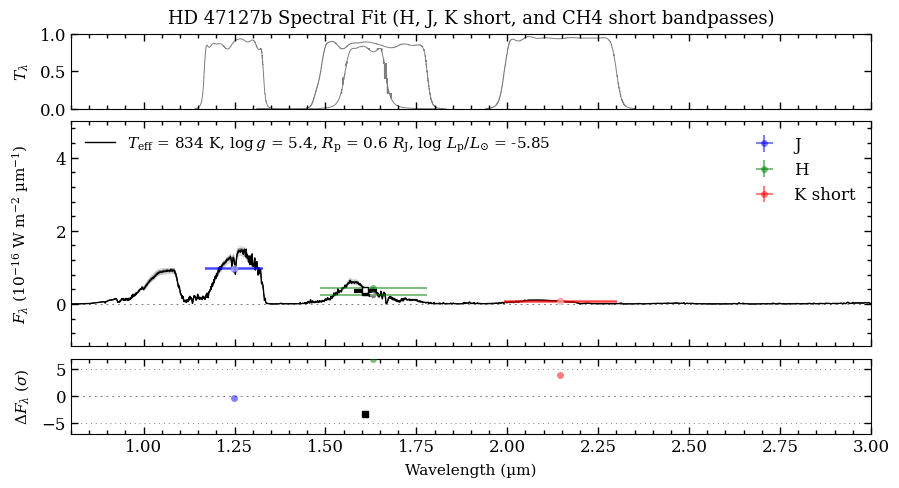

In [54]:
fig = plot_spectrum(boxes=[samples, modelbox, objectbox, synphot],
                    filters=objectbox.filters,
                    residuals=residuals,
                    plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                 {'ls': '-', 'lw': 1., 'color': 'black'},
                                 {'Keck/NIRC2.H': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'green', 'ls': 'none', 'alpha': 0.5, 'label': 'H'},
                                  'Keck/NIRC2.J': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'blue', 'ls': 'none', 'alpha': 0.5, 'label': 'J'},
                                  'Keck/NIRC2.Ks': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'red', 'ls': 'none', 'alpha': 0.5, 'label': 'K short'}},
                                 None],
                    xlim=(0.8, 3.0),
                    ylim=(-1.15e-16, .5e-15),
                    ylim_res=(-7., 7.),
                    scale=('linear', 'linear'),
                    offset=(-0.4, -0.05),
                    legend=[{'loc': 'upper left', 'frameon': False, 'fontsize': 11.},
                            {'loc': 'upper right', 'frameon': False, 'fontsize': 12.}],
                    figsize=(8., 4.),
                    quantity='flux density',
                    title='HD 47127b Spectral Fit (H, J, K short, and CH4 short bandpasses)',
                    output=model_name+'_spectrum.pdf')

In [19]:
####    EVOLUTIONARY MODELS    ####

In [3]:
SpeciesInit()

species v0.9.0

Working folder: C:\Users\benlc\hd47127b\species

Configuration file: C:\Users\benlc\hd47127b\species\species_config.ini
Database file: C:\Users\benlc\hd47127b\species\species_database.hdf5
Data folder: C:\Users\benlc\hd47127b\species\data

Configuration settings:
   - Database: C:\Users\benlc\hd47127b\species\species_database.hdf5
   - Data folder: C:\Users\benlc\hd47127b\species\data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


In [3]:
database = Database()

In [7]:
mass, mass_e_low, mass_e_high = 83.9, 8.7, 11
log_lum, lum_e_low, lum_e_high = -5.833, .015, .018


half_lum = math.log(0.5 * (10 ** log_lum), 10)
print(half_lum)

-6.1340299956639806


In [ ]:
#### EVO MODEL --> AMES-Dusty ####

In [4]:
database.add_isochrones(model='ames')

NameError: name 'database' is not defined

In [3]:
read_iso=ReadIsochrone(tag='ames-dusty')

NameError: name 'ReadIsochrone' is not defined

In [2]:
iso_box_1 = read_iso.get_isochrone(age=7000.,
                                 masses=np.linspace(15., 78., 30),
                                 filter_mag='H',
                                 filters_color=('J', 'Ks'))
iso_box_2 = read_iso.get_isochrone(age=10000.,
                                 masses=np.linspace(15., 78., 30),
                                 filter_mag='H',
                                 filters_color=('J', 'Ks'))

mass_est = np.arange(20, 80)
lum_low = [-log_lum-lum_e_low] * 60
lum_high = [-log_lum+lum_e_high] * 60

plt.plot(iso_box_1.mass, iso_box_1.log_lum, label=f'Age = {iso_box_1.age} Myr', color='c')
plt.plot(iso_box_2.mass, iso_box_2.log_lum, label=f'Age = {iso_box_2.age} Myr', color='b')
# plt.plot(mass_est, lum_low)
# plt.plot(mass_est, lum_high)


f_iso_low = interp1d(iso_box_1.mass, iso_box_1.log_lum, kind='linear', fill_value='extrapolate')
f_iso_high = interp1d(iso_box_2.mass, iso_box_2.log_lum, kind='linear', fill_value='extrapolate')


intersect_mass_low = fsolve(lambda x: f_iso_low(x) - lum_low[0], 40)

intersect_mass_high = fsolve(lambda x: f_iso_high(x) - lum_high[0], 40)

print("Dynamical mass prediction: [ ", intersect_mass_low[0], ",", intersect_mass_high[0], "]")

# plt.axvline(intersect_mass_low)
# plt.axvline(intersect_mass_high)

plt.errorbar(mass, log_lum, yerr=[[lum_e_low], [lum_e_high]], xerr=mass_e_high, capsize=3.0, color='r')
plt.plot(mass, log_lum, '.', color='r')
plt.annotate("single source", (mass, log_lum), xytext=(-50.0, 5), fontsize=14, textcoords='offset pixels')

half_lum = math.log(0.5 * (10 ** log_lum), 10)
print(half_lum)

plt.errorbar(mass/2, half_lum, yerr=[[lum_e_low], [lum_e_high]], xerr=mass_e_high, capsize=3.0, color='m')
plt.plot(mass/2, half_lum, '.', color='m')
plt.annotate("half of binary", (mass/2, half_lum), xytext=(0, 5.0), fontsize=14, textcoords='offset pixels')

plt.annotate("AMES-Dusty", (77, -6.85), fontsize=14)

# lum_1, lum_2 = math.log(0.4 * (10 ** -5.571), 10), math.log(0.6 * (10 ** -5.571), 10)
# plt.errorbar(37, lum_1, yerr=[[0.035], [0.049]], xerr=6.9, capsize=3.0, color='m')
# plt.plot(37, lum_1, '.', color='m')
# plt.errorbar(43, lum_2, yerr=[[0.035], [0.049]], xerr=6.9, capsize=3.0, color='m')
# plt.plot(43, lum_2, '.', color='m')


plt.xlabel(r'Mass ($M_\mathrm{J}$)', fontsize=14)
plt.ylabel(r'$\log(L/L_\odot)$', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.xlim(20, 100)
plt.ylim(-7, -4)
plt.legend(fontsize=14)

plt.savefig('ames_dusty.pdf', bbox_inches='tight')
plt.show()

NameError: name 'read_iso' is not defined

In [17]:
# print(len(iso_box_1.mass), len(iso_box_1.log_lum))
# print(iso_box_1.log_lum)
# print(iso_box_2.log_lum)

# lum_ind = list(iso_box_2.log_lum).index(-5.75) # about 15

def lumToMass(iso_box, target_lum):
    diff = float('inf')
    lum_ind = -1
    
    for i in range(len(iso_box.log_lum)):
        cur_diff = abs(iso_box.log_lum[i] - target_lum)
        if cur_diff < diff:
            diff = cur_diff
            lum_ind = i

    return iso_box.mass[lum_ind] if lum_ind > -1 else -1
            
    
target_lum = -5.751

print(lumToMass(iso_box_1, target_lum))
print(lumToMass(iso_box_2, target_lum))

43.241379310344826
47.58620689655173


In [26]:
mass_H1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='H',
                                   star_mag=5.277,
                                   contrast=[13.2794],
                                   use_mag=True)
mass_H2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='H',
                                   star_mag=5.277,
                                   contrast=[13.2794],
                                   use_mag=True)
mass_J1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='J',
                                   star_mag=5.561,
                                   contrast=[13.2129],
                                   use_mag=True)
mass_J2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='J',
                                   star_mag=5.561,
                                   contrast=[13.2129],
                                   use_mag=True)
mass_Ks1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='Ks',
                                   star_mag=5.174,
                                   contrast=[14.1645],
                                   use_mag=True)
mass_Ks2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='Ks',
                                   star_mag=5.174,
                                   contrast=[14.1645],
                                   use_mag=True)

print(mass_H1, mass_H2)
print(mass_J1, mass_J2)
print(mass_Ks1, mass_Ks2)

The 'H' filter is found in the list of available filters from the isochrone data of 'ames-dusty'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'H' filter is found in the list of available filters from the isochrone data of 'ames-dusty'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'J' filter is found in the list of available filters from the isochrone data of 'ames-dusty'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'J' filter is found in the list of available filters from the isochrone data of 'ames-dusty'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'Ks' filter is found in the list of available filters from the isochrone data of 'ames-dusty'.
The requested contrast values will be directly interpolated from the grid with pre-ca

In [22]:
#### EVO MODEL --> ATMO-CEQ ####

In [28]:
database.add_isochrones(model='atmo')


------------------
Add isochrone grid
------------------

Evolutionary model: atmo
File name: None
Database tag: None

Unpacking ATMO isochrones (9.6 MB)... [DONE]
Adding isochrones: ATMO equilibrium chemistry... [DONE]
Database tag: atmo-ceq
Adding isochrones: ATMO non-equilibrium chemistry (weak)... [DONE]
Database tag: atmo-neq-weak
Adding isochrones: ATMO non-equilibrium chemistry (strong)... [DONE]
Database tag: atmo-neq-strong

-------------------
Read isochrone grid
-------------------

Database tag: atmo-ceq
Create regular grid: False


In [89]:
read_iso = ReadIsochrone(tag='atmo-ceq')


-------------------
Read isochrone grid
-------------------

Database tag: atmo-ceq
Create regular grid: False


In [59]:
print(read_iso.get_filters())

['MKO_Y', 'MKO_J', 'MKO_H', 'MKO_K', 'MKO_Lp', 'MKO_Mp', 'W1', 'W2', 'W3', 'W4', 'IRAC_CH1', 'IRAC_CH2']


Dynamical mass prediction: [  41.28614309176409 , 47.3468478707398 ]


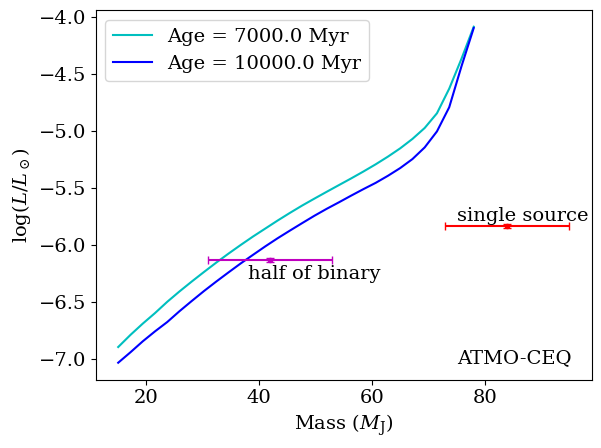

In [93]:
iso_box_1 = read_iso.get_isochrone(age=7000.,
                                 masses=np.linspace(15., 78., 30),
                                 filter_mag='MKO_H',
                                 filters_color=('MKO_J', 'MKO_K'))
iso_box_2 = read_iso.get_isochrone(age=10000.,
                                 masses=np.linspace(15., 78., 30),
                                 filter_mag='MKO_H',
                                 filters_color=('MKO_J', 'MKO_K'))

mass_est = np.arange(10, 80)
lum_low = [log_lum-lum_e_low] * 70
lum_high = [log_lum+lum_e_high] * 70

plt.plot(iso_box_1.mass, iso_box_1.log_lum, label=f'Age = {iso_box_1.age} Myr', color='c')
plt.plot(iso_box_2.mass, iso_box_2.log_lum, label=f'Age = {iso_box_2.age} Myr', color='b')
# plt.plot(mass_est, lum_low)
# plt.plot(mass_est, lum_high)


f_iso_low = interp1d(iso_box_1.mass, iso_box_1.log_lum, kind='linear', fill_value='extrapolate')
f_iso_high = interp1d(iso_box_2.mass, iso_box_2.log_lum, kind='linear', fill_value='extrapolate')

intersect_mass_low = fsolve(lambda x: f_iso_low(x) - lum_low[0], 10)

intersect_mass_high = fsolve(lambda x: f_iso_high(x) - lum_high[0], 10)

print("Dynamical mass prediction: [ ", intersect_mass_low[0], ",", intersect_mass_high[0], "]")

plt.errorbar(mass, log_lum, yerr=[[lum_e_low], [lum_e_high]], xerr=mass_e_high, capsize=3.0, color='r')
plt.plot(mass, log_lum, '.', color='r')
plt.annotate("single source", (mass, log_lum), xytext=(-50.0, 5), fontsize=14, textcoords='offset pixels')

half_lum = math.log(0.5 * (10 ** log_lum), 10)

plt.errorbar(mass/2, half_lum, yerr=[[lum_e_low], [lum_e_high]], xerr=mass_e_high, capsize=3.0, color='m')
plt.plot(mass/2, half_lum, '.', color='m')
plt.annotate("half of binary", (mass/2, half_lum), xytext=(-22, -18.0), fontsize=14, textcoords='offset pixels')

plt.annotate("ATMO-CEQ", (75, -7.03), fontsize=14)

plt.xlabel(r'Mass ($M_\mathrm{J}$)', fontsize=14)
plt.ylabel(r'$\log(L/L_\odot)$', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)

plt.savefig('atmo_ceq.pdf', bbox_inches='tight')
plt.show()


In [21]:
mass_H1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='MKO_H',
                                   star_mag=5.277,
                                   contrast=[13.2794],
                                   use_mag=True)
mass_H2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='MKO_H',
                                   star_mag=5.277,
                                   contrast=[13.2794],
                                   use_mag=True)
mass_J1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='MKO_J',
                                   star_mag=5.561,
                                   contrast=[13.2129],
                                   use_mag=True)
mass_J2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='MKO_J',
                                   star_mag=5.561,
                                   contrast=[13.2129],
                                   use_mag=True)
mass_Ks1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='MKO_K',
                                   star_mag=5.174,
                                   contrast=[14.1645],
                                   use_mag=True)
mass_Ks2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='MKO_K',
                                   star_mag=5.174,
                                   contrast=[14.1645],
                                   use_mag=True)

print(mass_H1, mass_H2)
print(mass_J1, mass_J2)
print(mass_Ks1, mass_Ks2)

The 'MKO_H' filter is found in the list of available filters from the isochrone data of 'atmo-ceq'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'MKO_H' filter is found in the list of available filters from the isochrone data of 'atmo-ceq'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'MKO_J' filter is found in the list of available filters from the isochrone data of 'atmo-ceq'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'MKO_J' filter is found in the list of available filters from the isochrone data of 'atmo-ceq'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'MKO_K' filter is found in the list of available filters from the isochrone data of 'atmo-ceq'.
The requested contrast values will be directly interpolated from the grid wi

#### EVO MODEL --> AMES-COND ####

In [21]:
database.add_isochrones(model='ames')


------------------
Add isochrone grid
------------------

Evolutionary model: ames
File name: None
Database tag: None

Adding isochrones: ames-cond... [DONE]
Database tag: ames-cond

Adding isochrones: ames-dusty... [DONE]
Database tag: ames-dusty


In [70]:
read_iso = ReadIsochrone(tag='ames-cond')


-------------------
Read isochrone grid
-------------------

Database tag: ames-cond
Create regular grid: False


In [14]:
print(read_iso.get_filters())

['J', 'H', 'Ks', "L'", "M'"]


In [71]:
iso_box_1 = read_iso.get_isochrone(age=7000.,
                                 masses=np.linspace(15.,78.,30),
                                 filter_mag='H',
                                 filters_color=('J','Ks'))
iso_box_2 = read_iso.get_isochrone(age=10000.,
                                 masses=np.linspace(15.,78.,30),
                                 filter_mag='H',
                                 filters_color=('J','Ks'))

### iso_box_1.open_box()

In [26]:
print(iso_box_1.age)

7000.0


Dynamical mass prediction: [  41.98318181348478 , 48.15422123842515 ]


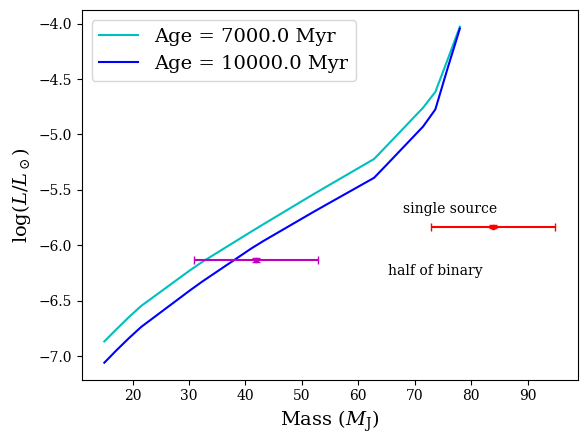

In [73]:
mass_est = np.arange(10, 80)
lum_low = [log_lum-lum_e_low] * 70
lum_high = [log_lum+lum_e_high] * 70

plt.plot(iso_box_1.mass, iso_box_1.log_lum, label=f'Age = {iso_box_1.age} Myr', color='c')
plt.plot(iso_box_2.mass, iso_box_2.log_lum, label=f'Age = {iso_box_2.age} Myr', color='b')
# plt.plot(mass_est, lum_high)
# plt.plot(mass_est, lum_low)

f_iso_low = interp1d(iso_box_1.mass, iso_box_1.log_lum, kind='linear', fill_value='extrapolate')
f_iso_high = interp1d(iso_box_2.mass, iso_box_2.log_lum, kind='linear', fill_value='extrapolate')
intersect_mass_low = fsolve(lambda x: f_iso_low(x) - lum_low[0], 10)
intersect_mass_high = fsolve(lambda x: f_iso_high(x) - lum_high[0], 10)
print("Dynamical mass prediction: [ ", intersect_mass_low[0], ",", intersect_mass_high[0], "]")


plt.errorbar(mass, log_lum, yerr=[[lum_e_low], [lum_e_high]], xerr=mass_e_high, capsize=3.0, color='r')
plt.plot(mass, log_lum, '.', color='r')
plt.annotate("single source", (mass, -5.571), xytext=(-90.0, -15.0), textcoords='offset pixels')

half_lum = math.log(0.5 * (10 ** log_lum), 10)

plt.errorbar(mass/2, half_lum, yerr=[[lum_e_low], [lum_e_high]], xerr=mass_e_high, capsize=3.0, color='m')
plt.plot(mass/2, half_lum, '.', color='m')
plt.annotate("half of binary", (mass, half_lum), xytext=(-105.0, -15.0), textcoords='offset pixels')

plt.xlabel(r'Mass ($M_\mathrm{J}$)', fontsize=14)
plt.ylabel(r'$\log(L/L_\odot)$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [37]:
# plt.plot(iso_box_1.mass, iso_box_1.magnitude, label=f'Age = {iso_box_1.age} Myr')
# plt.plot(iso_box_2.mass, iso_box_2.magnitude, label=f'Age = {iso_box_2.age} Myr')
# plt.xlabel(r'Mass ($M_\mathrm{J}$)', fontsize=14)
# plt.ylabel(iso_box_1.filter_mag, fontsize=14)
# plt.gca().invert_yaxis()
# plt.legend(fontsize=14)
# # plt.show()

Cooling box, providing fixed mass to plot against luminosity and age

In [30]:
cooling_box_1 = read_iso.get_cooling_track(mass=73. - 6.9,
                                         ages=None,
                                         filters_color=None,
                                         filter_mag=None)
cooling_box_2 = read_iso.get_cooling_track(mass=78.,
                                         ages=None,
                                         filters_color=None,
                                         filter_mag=None)

In [31]:
cooling_box_1.open_box()

Opening CoolingBox...
model = ames-cond
mass = 66.1
age = [1.0e+00 2.0e+00 3.0e+00 4.0e+00 5.0e+00 6.0e+00 7.0e+00 8.0e+00 9.0e+00
 1.0e+01 2.0e+01 3.0e+01 4.0e+01 5.0e+01 6.0e+01 7.0e+01 8.0e+01 9.0e+01
 1.0e+02 1.2e+02 1.5e+02 2.0e+02 3.0e+02 4.0e+02 5.0e+02 6.0e+02 7.0e+02
 8.0e+02 9.0e+02 1.0e+03 2.0e+03 3.0e+03 4.0e+03 5.0e+03 6.0e+03 7.0e+03
 8.0e+03 9.0e+03 1.0e+04 1.2e+04]
teff = [2832.98616871 2837.2960366  2846.15524392 2866.70458335 2887.70458335
 2903.94405489 2900.94405489 2895.25392278 2889.56379067 2885.87365855
 2850.97233742 2825.45128051 2804.62035572 2783.16969515 2763.64863824
 2742.74731711 2722.29665654 2702.77559963 2683.32493907 2645.35322159
 2591.31110777 2512.02952241 2377.39595535 2268.42423787 2182.00185983
 2107.1005387  2042.05842488 1986.39657529 1934.66432937 1888.07287612
 1586.58072168 1425.04583348 1317.97543714 1245.18662616 1191.77807941
 1147.36953266 1109.96098591 1077.24257127 1048.83402451 1002.04521354]
log_lum = [-1.56281585 -1.59591453 -1.66

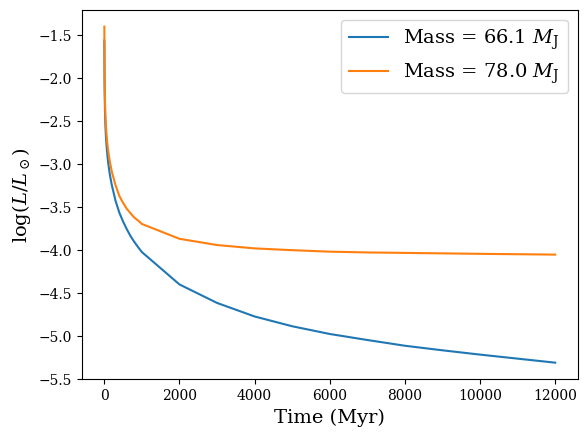

In [32]:
plt.plot(cooling_box_1.age, cooling_box_1.log_lum, label=f'Mass = {cooling_box_1.mass}'+r' $M_\mathrm{J}$')
plt.plot(cooling_box_2.age, cooling_box_2.log_lum, label=f'Mass = {cooling_box_2.mass}'+r' $M_\mathrm{J}$')
plt.xlabel(r'Time (Myr)', fontsize=14)
plt.ylabel(r'$\log(L/L_\odot)$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [35]:
mass_H1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='H',
                                   star_mag=5.277,
                                   contrast=[13.2794],
                                   use_mag=True)
mass_H2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='H',
                                   star_mag=5.277,
                                   contrast=[13.2794],
                                   use_mag=True)
mass_J1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='J',
                                   star_mag=5.561,
                                   contrast=[13.2129],
                                   use_mag=True)
mass_J2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='J',
                                   star_mag=5.561,
                                   contrast=[13.2129],
                                   use_mag=True)
mass_Ks1 = read_iso.contrast_to_mass(age=7000.,
                                   distance=26.6,
                                   filter_name='Ks',
                                   star_mag=5.174,
                                   contrast=[14.1645],
                                   use_mag=True)
mass_Ks2 = read_iso.contrast_to_mass(age=10000.,
                                   distance=26.6,
                                   filter_name='Ks',
                                   star_mag=5.174,
                                   contrast=[14.1645],
                                   use_mag=True)

print(mass_H1, mass_H2)
print(mass_J1, mass_J2)
print(mass_Ks1, mass_Ks2)

The 'H' filter is found in the list of available filters from the isochrone data of 'ames-cond'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'H' filter is found in the list of available filters from the isochrone data of 'ames-cond'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'J' filter is found in the list of available filters from the isochrone data of 'ames-cond'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'J' filter is found in the list of available filters from the isochrone data of 'ames-cond'.
The requested contrast values will be directly interpolated from the grid with pre-calculated magnitudes.
The 'Ks' filter is found in the list of available filters from the isochrone data of 'ames-cond'.
The requested contrast values will be directly interpolated from the grid with pre-calcula

In [36]:
phot_box_1 = read_iso.get_photometry(age=7000., mass=73., distance=26.6, filter_name='Keck/NIRC2.H')

In [54]:
color_mag_box = read_iso.get_color_magnitude(age=7000.,
                                             masses=None,
                                             filters_color=('Keck/NIRC2.J', 'Keck/NIRC2.Ks'),
                                             filter_mag = 'Keck/NIRC2.J')


----------------------------
Plot color-magnitude diagram
----------------------------

Boxes:
   - ColorMagBox

Objects: None

Spectral range: None
Companion labels: False
Accretion markers: False

Mass labels: {'ames-cond': [(15.0, 'right'), (30.0, 'left'), (50.0, 'left'), (70.0, 'right')]}
Teff labels: None

Reddening: None

Figure size: (4.0, 4.8)
Limits x axis: (-1.5, 1.5)
Limits y axis: None


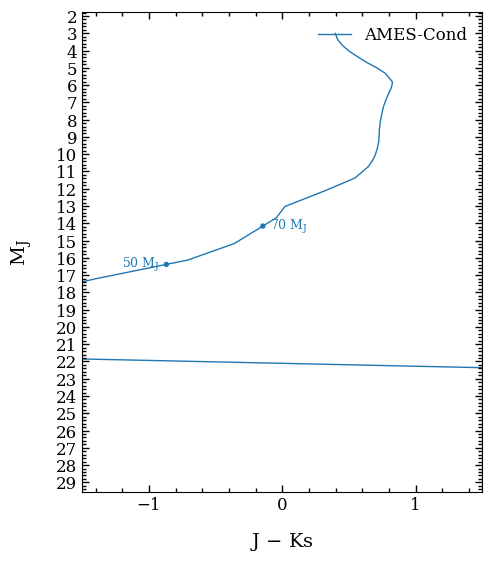

In [55]:
fig = plot_color_magnitude(boxes=[color_mag_box],
                           mass_labels={'ames-cond': [(15., 'right'), (30., 'left'), (50., 'left'), (70., 'right')]},
                           label_x=r"J $-$ Ks",
                           label_y=r"M$_\mathrm{J}$",
                           xlim=(-1.5, 1.5),
                           legend={'loc': 'upper right', 'frameon': False, 'fontsize': 12.})

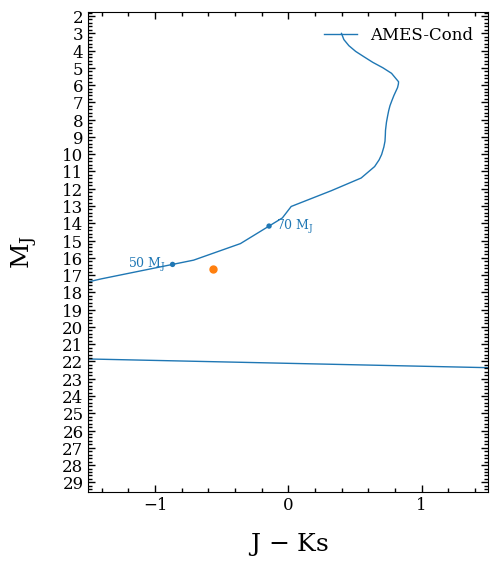

In [56]:
import math

diff = appmag['Keck/NIRC2.J'][0] - appmag['Keck/NIRC2.Ks'][0]
mag = appmag['Keck/NIRC2.J'][0]
abs_mag = mag - 5 * math.log(26.6, 10) + 5

fig.axes[0].plot(diff, abs_mag, 'o', color='tab:orange', ms=5, label='HD47127 B')
fig.axes[0].xaxis.label.set_fontsize(18.)
fig.axes[0].yaxis.label.set_fontsize(18.)
fig

#### EVO MODEL --> Saumon ####

In [65]:
database.add_isochrones(model='saumon2008')


------------------
Add isochrone grid
------------------

Evolutionary model: saumon2008
File name: None
Database tag: None



100%|########################################| 255k/255k [00:00<00:00, 128MB/s]


Unpacking Saumon & Marley (2008) isochrones (800 kB)...

 [DONE]

Adding isochrones: Saumon & Marley (2008) Cloudless [M/H] = 0.0... [DONE]
Database tag: saumon2008-nc_solar

Adding isochrones: Saumon & Marley (2008) Cloudless [M/H] = -0.3... [DONE]
Database tag: saumon2008-nc_-0.3

Adding isochrones: Saumon & Marley (2008) Cloudless [M/H] = +0.3... [DONE]
Database tag: saumon2008-nc_+0.3

Adding isochrones: Saumon & Marley (2008) Cloudy f_sed = 2... [DONE]
Database tag: saumon2008-f2_solar

Adding isochrones: Saumon & Marley (2008) Hybrid (cloudless / f_sed = 2)... [DONE]
Database tag: saumon2008-hybrid_solar


In [94]:
saumon = ReadIsochrone(tag='saumon2008-nc_solar')
print(saumon.get_filters())


-------------------
Read isochrone grid
-------------------

Database tag: saumon2008-nc_solar
Create regular grid: False
None


In [95]:
iso_box_1 = saumon.get_isochrone(age=7000.,
                               masses=np.linspace(15.,75.,50))
iso_box_2 = saumon.get_isochrone(age=10000.,
                                 masses=np.linspace(15.,75.,50))

In [82]:
iso_box_1.open_box()

Opening IsochroneBox...
model = saumon2008-nc_solar
age = 7000.0
mass = [15.         16.2244898  17.44897959 18.67346939 19.89795918 21.12244898
 22.34693878 23.57142857 24.79591837 26.02040816 27.24489796 28.46938776
 29.69387755 30.91836735 32.14285714 33.36734694 34.59183673 35.81632653
 37.04081633 38.26530612 39.48979592 40.71428571 41.93877551 43.16326531
 44.3877551  45.6122449  46.83673469 48.06122449 49.28571429 50.51020408
 51.73469388 52.95918367 54.18367347 55.40816327 56.63265306 57.85714286
 59.08163265 60.30612245 61.53061224 62.75510204 63.97959184 65.20408163
 66.42857143 67.65306122 68.87755102 70.10204082 71.32653061 72.55102041
 73.7755102  75.        ]
teff = [ 340.14587562  356.32926172  371.1937343   387.55820688  402.92820236
  418.36883605  434.81936573  449.51379761  464.88056979  479.98664498
  495.60169246  510.88563084  526.49285583  541.17394232  556.11181456
  571.10989822  584.74343073  598.75585243  615.40564572  631.34336722
  645.75968831  661.1859021

Dynamical mass prediction: [  42.27433738194379 , 51.66672179853746 ]


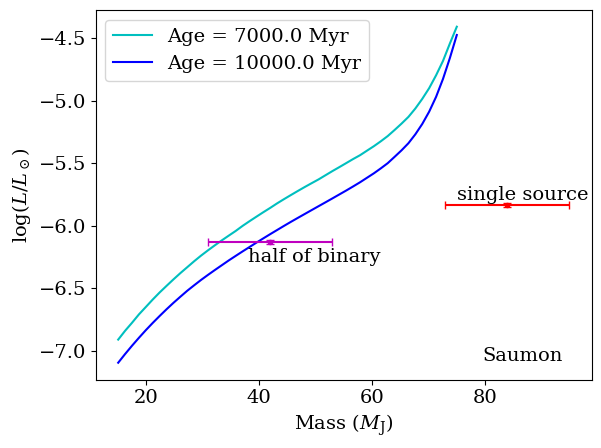

In [96]:
mass_est = np.arange(10, 80)
lum_low = [log_lum-lum_e_low] * 70
lum_high = [log_lum+lum_e_high] * 70

plt.plot(iso_box_1.mass, iso_box_1.log_lum, label=f'Age = {iso_box_1.age} Myr', color='c')
plt.plot(iso_box_2.mass, iso_box_2.log_lum, label=f'Age = {iso_box_2.age} Myr', color='b')
# plt.plot(mass_est, lum_high)
# plt.plot(mass_est, lum_low)

f_iso_low = interp1d(iso_box_1.mass, iso_box_1.log_lum, kind='linear', fill_value='extrapolate')
f_iso_high = interp1d(iso_box_2.mass, iso_box_2.log_lum, kind='linear', fill_value='extrapolate')
intersect_mass_low = fsolve(lambda x: f_iso_low(x) - lum_low[0], 10)
intersect_mass_high = fsolve(lambda x: f_iso_high(x) - lum_high[0], 10)
print("Dynamical mass prediction: [ ", intersect_mass_low[0], ",", intersect_mass_high[0], "]")


plt.errorbar(mass, log_lum, yerr=[[lum_e_low], [lum_e_high]], xerr=mass_e_high, capsize=3.0, color='r')
plt.plot(mass, log_lum, '.', color='r')
plt.annotate("single source", (mass, log_lum), xytext=(-50.0, 5.0), fontsize=14, textcoords='offset pixels')

half_lum = math.log(0.5 * (10 ** log_lum), 10)

plt.errorbar(mass/2, half_lum, yerr=[[lum_e_low], [lum_e_high]], xerr=mass_e_high, capsize=3.0, color='m')
plt.plot(mass/2, half_lum, '.', color='m')
plt.annotate("half of binary", (mass/2, half_lum), xytext=(-22.0, -20.0), fontsize=14, textcoords='offset pixels')

plt.annotate("Saumon", (79.5, -7.08), fontsize=14)

plt.xlabel(r'Mass ($M_\mathrm{J}$)', fontsize=14)
plt.ylabel(r'$\log(L/L_\odot)$', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14)

plt.savefig('saumon.pdf', bbox_inches='tight')
plt.show()

In [123]:
color_mag_box = saumon.get_color_magnitude(age=10000.,
                                             masses=None,
                                             filters_color=('Keck/NIRC2.J', 'Keck/NIRC2.Ks'),
                                             filter_mag = 'Keck/NIRC2.J')

C:\Users\benlc\hd47127b\spec\Lib\site-packages\species\read\read_isochrone.py:1020: UserWarning: The value of teff is 292.00000000000006, which is below the lower bound of the model grid (500.0). Setting the magnitudes to NaN for the following isochrone sample: {'teff': 292.00000000000006, 'logg': 4.5440000000000005, 'radius': 0.9818739159626252, 'distance': 10.0}.
  warnings.warn(
C:\Users\benlc\hd47127b\spec\Lib\site-packages\species\read\read_isochrone.py:1020: UserWarning: The value of teff is 304.0, which is below the lower bound of the model grid (500.0). Setting the magnitudes to NaN for the following isochrone sample: {'teff': 304.0, 'logg': 4.583, 'radius': 0.9731158731046831, 'distance': 10.0}.
  warnings.warn(
C:\Users\benlc\hd47127b\spec\Lib\site-packages\species\read\read_isochrone.py:1020: UserWarning: The value of teff is 316.0, which is below the lower bound of the model grid (500.0). Setting the magnitudes to NaN for the following isochrone sample: {'teff': 316.0, 'log


----------------------------
Plot color-magnitude diagram
----------------------------

Boxes:
   - ColorMagBox

Objects: None

Spectral range: None
Companion labels: False
Accretion markers: False

Mass labels: {'saumon': [(1.0, 'right'), (5.0, 'left'), (10.0, 'left'), (30.0, 'right')]}
Teff labels: None

Reddening: None

Figure size: (4.0, 4.8)
Limits x axis: (-1.5, 1.5)
Limits y axis: None


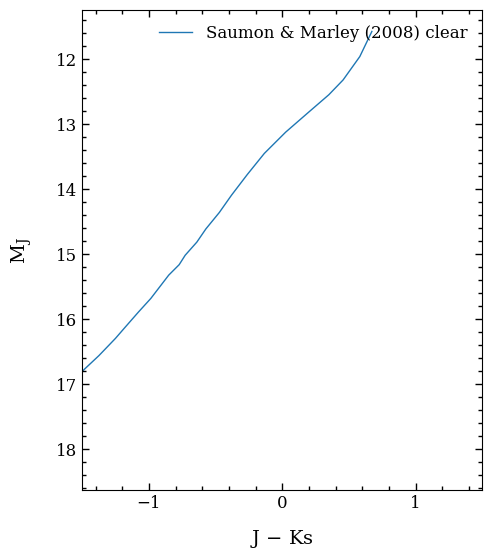

In [124]:
fig = plot_color_magnitude(boxes=[color_mag_box],
                           mass_labels={'saumon': [(1., 'right'), (5., 'left'), (10., 'left'), (30., 'right')]},
                           label_x=r"J $-$ Ks",
                           label_y=r"M$_\mathrm{J}$",
                           xlim=(-1.5, 1.5),
                           legend={'loc': 'upper right', 'frameon': False, 'fontsize': 12.})

In [125]:
diff = appmag['Keck/NIRC2.J'][0] - appmag['Keck/NIRC2.Ks'][0]
mag = appmag['Keck/NIRC2.J'][0]

fig.axes[0].plot(diff, mag, 'o', color='tab:orange', ms=5, label='HD47127 B')
fig.axes[0].xaxis.label.set_fontsize(18.)
fig.axes[0].yaxis.label.set_fontsize(18.)

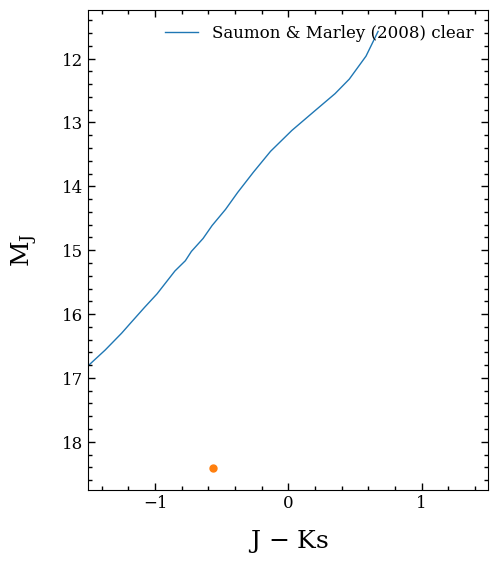

In [126]:
fig

In [ ]:
#### EVO MODEL -> ####